# Setup and image processing
Import of all necessary libraries. Make sure you installed all necessary packages in your environment.

In [2]:
import os
import re
import numpy as np
import pandas as pd
from PIL import Image
from segment_anything import sam_model_registry, SamPredictor
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

Loading of the SAM Model. 

Make sure that you downloaded the SAM-Model Checkpoint (vit_l in this case) and stored it in the correct directory. 

The model checkpoints can be downloaded from:
https://github.com/facebookresearch/segment-anything?tab=readme-ov-file#model-checkpoints

More details on how the SAM model works and how it can be installed can be found on this repository as well.

In [ ]:
# Load SAM Model
model_type = "vit_l"
sam = sam_model_registry[model_type](checkpoint="./sam_vit_l_0b3195.pth")   # Change directory to where the model is saved
predictor = SamPredictor(sam)

c:\Users\dave-\anaconda3\envs\MoIm\Lib\site-packages\segment_anything\build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


## Image processing
Here the functions are defined for the processing of the images. Images are read, the groups are extracted using the identifier of the images, masks are generated and split into head and tail (head is defined as 1/3 of the fish length), masks are applied and the GFP signal is extracted. 

In [ ]:
def get_identifier(filename: str) -> str:
    """
    Extracts a unique identifier from a filename using a regular expression pattern.

    Args:
        filename (str): The filename to extract the identifier from.

    Returns:
        str: A unique identifier based on the filename, formatted as "<well>_<timepoint>".
        None: If the filename does not match the expected pattern.
    """
    match = re.match(r"^([A-D]\d+_\d+).*_(\d{3})\.tif$", filename)
    return f"{match.group(1)}_{match.group(2)}" if match else None

def split_mask(mask: np.array) -> tuple:
    """
    Splits a mask into two regions: head (first one-third) and tail (remaining two-thirds).

    Args:
        mask (np.array): A binary mask of the whole fish.

    Returns:
        tuple: Two numpy arrays representing the head mask and the tail mask.
    """
    split_index = mask.shape[1] // 3  # Compute the index for one-third of the image width

    head_mask = np.zeros_like(mask)  # Mask for the head (first one-third)
    tail_mask = np.zeros_like(mask)  # Mask for the tail (remaining two-thirds)

    # Assign regions to the respective masks
    head_mask[:, :split_index] = mask[:, :split_index]  # First one-third (head)
    tail_mask[:, split_index:] = mask[:, split_index:]  # Remaining two-thirds (tail)

    return head_mask, tail_mask

def process_images(input_dir: str, output_dir: str, 
                   save_masks: bool = True, save_masked_images: bool = True) -> pd.DataFrame:
    """
    Processes pairs of 'Phase Contrast' and 'GFP' images to generate binary masks, 
    calculate GFP intensity for whole fish, head, and tail regions, and save results.

    Args:
        input_dir (str): Directory containing input TIF images.
        output_dir (str): Directory to save masks, masked images, and results.
        save_masks (bool): Whether to save the generated masks.
        save_masked_images (bool): Whether to save the GFP images masked by fish, head, and tail masks.

    Returns:
        pd.DataFrame: A DataFrame containing GFP intensity data for each image pair.
    """
    # Define directories for saving outputs
    phase_mask_dir = os.path.join(output_dir, "phase_masks")
    head_mask_dir = os.path.join(output_dir, "head_masks")
    tail_mask_dir = os.path.join(output_dir, "tail_masks")
    masked_images_dir = os.path.join(output_dir, "masked_images")  # Folder for masked images
    masked_fish_dir = os.path.join(masked_images_dir, "fish")
    masked_head_dir = os.path.join(masked_images_dir, "head")
    masked_tail_dir = os.path.join(masked_images_dir, "tail")
    
    # Create output directories
    os.makedirs(output_dir, exist_ok=True)
    if save_masks:
        os.makedirs(phase_mask_dir, exist_ok=True)
        os.makedirs(head_mask_dir, exist_ok=True)
        os.makedirs(tail_mask_dir, exist_ok=True)
    if save_masked_images:
        os.makedirs(masked_images_dir, exist_ok=True)
        os.makedirs(masked_fish_dir, exist_ok=True)
        os.makedirs(masked_head_dir, exist_ok=True)
        os.makedirs(masked_tail_dir, exist_ok=True)

    # Collect Phase Contrast and GFP image pairs
    phase_contrast_files = {}
    gfp_files = {}
    for file_name in os.listdir(input_dir):
        if file_name.endswith(".tif"):
            identifier = get_identifier(file_name)
            if identifier:
                if "Phase Contrast" in file_name:
                    phase_contrast_files[identifier] = file_name
                elif "GFP" in file_name:
                    gfp_files[identifier] = file_name

    gfp_intensity_results = []  # To store the results

    # Process each image pair
    for i, (identifier, phase_file) in enumerate(phase_contrast_files.items()):
        if identifier in gfp_files:
            try:
                phase_path = os.path.join(input_dir, phase_file)
                gfp_path = os.path.join(input_dir, gfp_files[identifier])
                
                # Load and preprocess Phase Contrast image
                phase_image = Image.open(phase_path)
                phase_np = np.array(phase_image, dtype=np.uint16)
                phase_np = (phase_np / phase_np.max() * 255).astype(np.uint8)
                phase_rgb = np.stack([phase_np] * 3, axis=-1)

                predictor.set_image(phase_rgb)

                # Generate primary mask
                input_point = np.array([[phase_rgb.shape[1] // 2, phase_rgb.shape[0] // 2]])
                input_label = np.array([1])
                masks, scores, _ = predictor.predict(
                    point_coords=input_point,
                    point_labels=input_label,
                    multimask_output=False
                )
                primary_mask = masks[0]

                # Save whole fish mask
                if save_masks:
                    mask_output_path = os.path.join(phase_mask_dir, f"mask_{identifier}.png")
                    Image.fromarray((primary_mask * 255).astype(np.uint8)).save(mask_output_path)

                # Split mask into head and tail
                head_mask, tail_mask = split_mask(primary_mask)

                # Save head and tail masks
                if save_masks:
                    head_mask_output_path = os.path.join(head_mask_dir, f"head_mask_{identifier}.png")
                    tail_mask_output_path = os.path.join(tail_mask_dir, f"tail_mask_{identifier}.png")
                    Image.fromarray((head_mask * 255).astype(np.uint8)).save(head_mask_output_path)
                    Image.fromarray((tail_mask * 255).astype(np.uint8)).save(tail_mask_output_path)

                # Load GFP image
                gfp_image = Image.open(gfp_path)
                gfp_np = np.array(gfp_image, dtype=np.uint16)

                # Calculate GFP intensities for whole fish, head, and tail
                gfp_values_within_fish = gfp_np[primary_mask > 0]
                mean_gfp_intensity = gfp_values_within_fish.mean() if gfp_values_within_fish.size > 0 else 0
                total_gfp_intensity = gfp_values_within_fish.sum()

                gfp_values_within_head = gfp_np[head_mask > 0]
                mean_gfp_head = gfp_values_within_head.mean() if gfp_values_within_head.size > 0 else 0
                total_gfp_head = gfp_values_within_head.sum()

                gfp_values_within_tail = gfp_np[tail_mask > 0]
                mean_gfp_tail = gfp_values_within_tail.mean() if gfp_values_within_tail.size > 0 else 0
                total_gfp_tail = gfp_values_within_tail.sum()

                # Save masked GFP images
                if save_masked_images:
                    gfp_masked = gfp_np * primary_mask
                    head_masked = gfp_np * head_mask
                    tail_masked = gfp_np * tail_mask

                    fish_output_path = os.path.join(masked_fish_dir, f"masked_fish_{identifier}.png")
                    head_output_path = os.path.join(masked_head_dir, f"masked_head_{identifier}.png")
                    tail_output_path = os.path.join(masked_tail_dir, f"masked_tail_{identifier}.png")

                    Image.fromarray(gfp_masked.astype(np.uint16)).save(fish_output_path)
                    Image.fromarray(head_masked.astype(np.uint16)).save(head_output_path)
                    Image.fromarray(tail_masked.astype(np.uint16)).save(tail_output_path)

                # Append GFP intensity results
                gfp_intensity_results.append({
                    "Identifier": identifier,
                    "Mean_GFP_Intensity": mean_gfp_intensity,
                    "Total_GFP_Intensity": total_gfp_intensity,
                    "Mean_GFP_Head": mean_gfp_head,
                    "Total_GFP_Head": total_gfp_head,
                    "Mean_GFP_Tail": mean_gfp_tail,
                    "Total_GFP_Tail": total_gfp_tail
                })

            except Exception as e:
                print(f"Error processing {identifier}: {e}")

        # Display progress
        if (i + 1) % 5 == 0:
            print(f"Processed {i + 1}/{len(phase_contrast_files)} image pairs.")

    # Save results to CSV
    results_df = pd.DataFrame(gfp_intensity_results)
    csv_output_path = os.path.join(output_dir, "gfp_intensity_results_vit_l.csv")
    results_df.to_csv(csv_output_path, index=False)
    
    print(f"Results saved to {csv_output_path}") 
    return results_df

Define Input and Output directories. Change the directories to your choice.

In [ ]:
# Define paths
input_dir = r"Path to the folder containing the images"
output_dir = r"Path to the folder to save the results"
os.makedirs(output_dir, exist_ok=True)

Run the functions on all images in the defined input folder. It can be chosen whether the masks and/or the masked images will be saved.

The suggestions is to first run it with saving on (True) an input folder containing a few representative image pairs to check whether everything functions coerrectly.

If it does, run it on all images with saving turned off (False) in order to save disk space.

In [5]:
# Run the function
gfp_intensity_results_df = process_images(input_dir, output_dir, save_masks=True, save_masked_images=True)

Processed 5/8 image pairs.
Results saved to C:\Users\dave-\OneDrive - ZHAW\HS24\MoIm\MolecularIMaging\Images\test_images\output1\gfp_intensity_results_vit_l.csv


# Data processing of the generated csv file and data analysis

Here the csv data is processed, noise correction is applied and plots are generated.

Change file_path to the path where your csv filed is stored (defined in output_dir) in case the homedirectory is incorrect. 

Produced plots:

- Line plot with error bars - Corrected Mean GFP Intensity by Region and Treatment (GFP signal devided by area of the mask)
- Line plot with error bars - Corrected Total GFP Intensity by Region and Treatment (GFP signal of the whole area)
- Comparison of Corrected Mean GFP Intensity (All groups and regions)
- Stacked area plot of Corrected Total GFP Intensity by Region and Treatment
- Heatmap of Normalized Corrected Mean GFP Intensity by Treatment for every Region 
- Boxplot of Corrected Mean GFP Intensity by Treatment Group at Time Points t0, t30, and t60


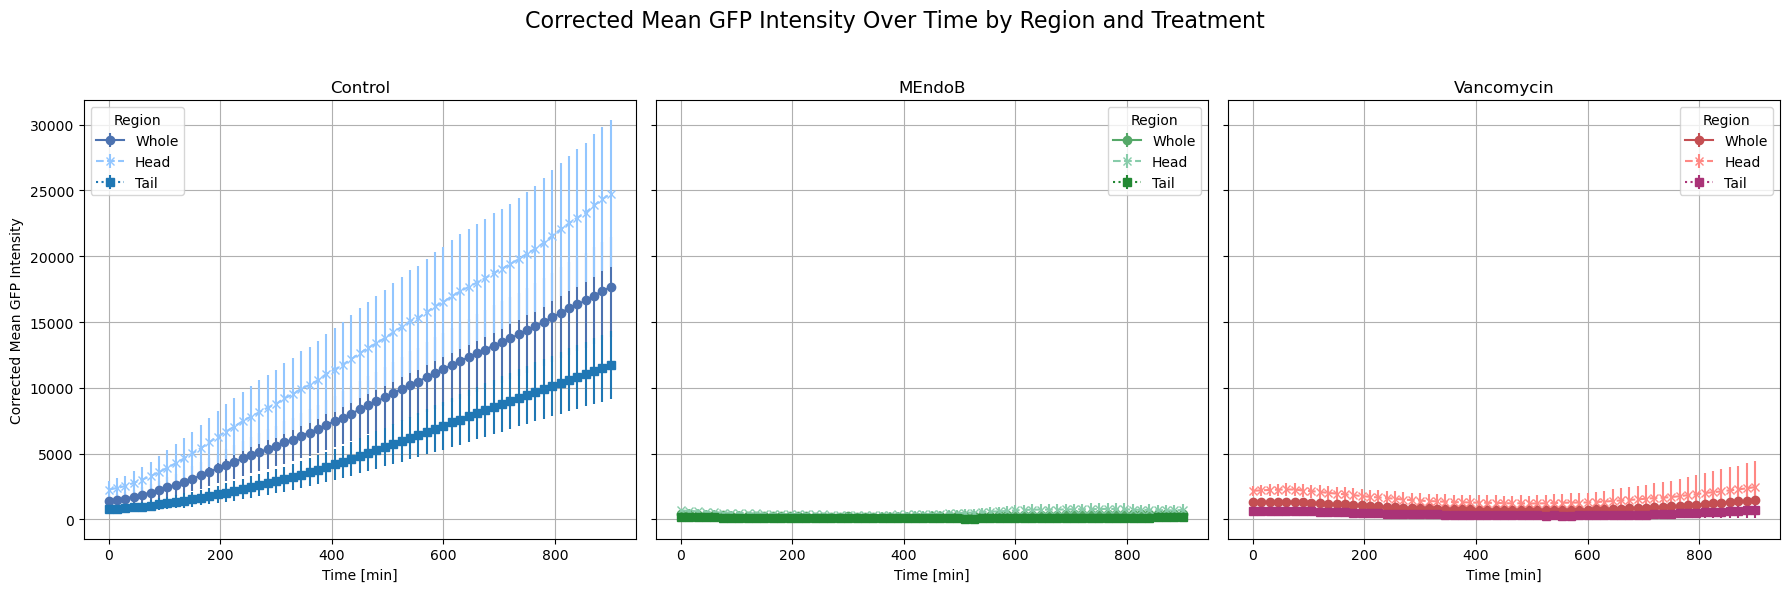

In [3]:
# Load the CSV file
file_path = "./gfp_intensity_results_vit_l.csv"
df = pd.read_csv(file_path)

# --- Data Preprocessing ---
# Extract group and treatment information
df['Group'] = df['Identifier'].str.extract(r'([A-D])')[0]
df['Treatment'] = df['Group'].map({'A': 'MEndoB', 'B': 'Vancomycin', 'C': 'Control', 'D': 'Blank'})
df['Time'] = (df['Identifier'].str.extract(r'_(\d+)$').astype(int)-1) * 15

# Calculate the mean intensity of the blank wells (D4-D6) for each time point
blank_summary = (
    df[df['Treatment'] == 'Blank']
    .groupby('Time')
    .agg(
        Blank_Mean_GFP_Intensity=('Mean_GFP_Intensity', 'mean'),
        Blank_Mean_Total_Intensity=('Total_GFP_Intensity', 'mean'),
        Blank_Mean_Head_Intensity=('Mean_GFP_Head', 'mean'),
        Blank_Mean_Tail_Intensity=('Mean_GFP_Tail', 'mean')
    )
    .reset_index()
)

# Merge the blank summary with the original data for noise correction
df = pd.merge(df, blank_summary, on='Time', how='left')

# Apply noise correction - Mean GFP Intensity of blank wells is subtracted from each well
df['Corrected_Mean_GFP_Intensity'] = df['Mean_GFP_Intensity'] - df['Blank_Mean_GFP_Intensity']
df['Corrected_Total_GFP_Intensity'] = df['Total_GFP_Intensity'] - df['Blank_Mean_Total_Intensity']
df['Corrected_Mean_Head_Intensity'] = df['Mean_GFP_Head'] - df['Blank_Mean_Head_Intensity']
df['Corrected_Total_Head_Intensity'] = df['Total_GFP_Head'] - df['Blank_Mean_Head_Intensity']
df['Corrected_Mean_Tail_Intensity'] = df['Mean_GFP_Tail'] - df['Blank_Mean_Tail_Intensity']
df['Corrected_Total_Tail_Intensity'] = df['Total_GFP_Tail'] - df['Blank_Mean_Tail_Intensity']

# Filter out the blank wells for further analysis
df = df[df['Treatment'] != 'Blank']

# Group by Treatment and Time to calculate mean and standard error for the line plot
summary = df.groupby(['Treatment', 'Time']).agg(
    Whole_Mean=('Corrected_Mean_GFP_Intensity', 'mean'),
    Whole_SEM=('Corrected_Mean_GFP_Intensity', 'sem'),
    Head_Mean=('Corrected_Mean_Head_Intensity', 'mean'),
    Head_SEM=('Corrected_Mean_Head_Intensity', 'sem'),
    Tail_Mean=('Corrected_Mean_Tail_Intensity', 'mean'),
    Tail_SEM=('Corrected_Mean_Tail_Intensity', 'sem'),
).reset_index()

# Define a custom color palette for better understanding
colors = {
    'Control': ['#4C72B0', '#92C6FF', '#1F77B4'],  # Shades of blue
    'MEndoB': ['#55A868', '#88CCAA', '#228833'],   # Shades of green
    'Vancomycin': ['#C44E52', '#FF8884', '#AA3377']  # Shades of red
}

# --- Line Plot for Mean GFP Intensities (Subplots) ---
treatments = summary['Treatment'].unique()
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), sharey=True)

for ax, treatment in zip(axes, treatments):
    subset = summary[summary['Treatment'] == treatment]
    
    # Plot each region
    ax.errorbar(subset['Time'], subset['Whole_Mean'], yerr=subset['Whole_SEM'], 
                label="Whole", linestyle='-', marker='o', color=colors[treatment][0])
    ax.errorbar(subset['Time'], subset['Head_Mean'], yerr=subset['Head_SEM'], 
                label="Head", linestyle='--', marker='x', color=colors[treatment][1])
    ax.errorbar(subset['Time'], subset['Tail_Mean'], yerr=subset['Tail_SEM'], 
                label="Tail", linestyle=':', marker='s', color=colors[treatment][2])
    
    # Set axis labels, grid, and title
    ax.set_title(treatment)
    ax.set_xlabel("Time [min]")
    ax.grid()
    
    # Add a legend for each subplot
    ax.legend(title="Region")

# Add shared y-axis label
axes[0].set_ylabel("Corrected Mean GFP Intensity")

# Add a shared title and adjust layout
fig.suptitle("Corrected Mean GFP Intensity Over Time by Region and Treatment", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

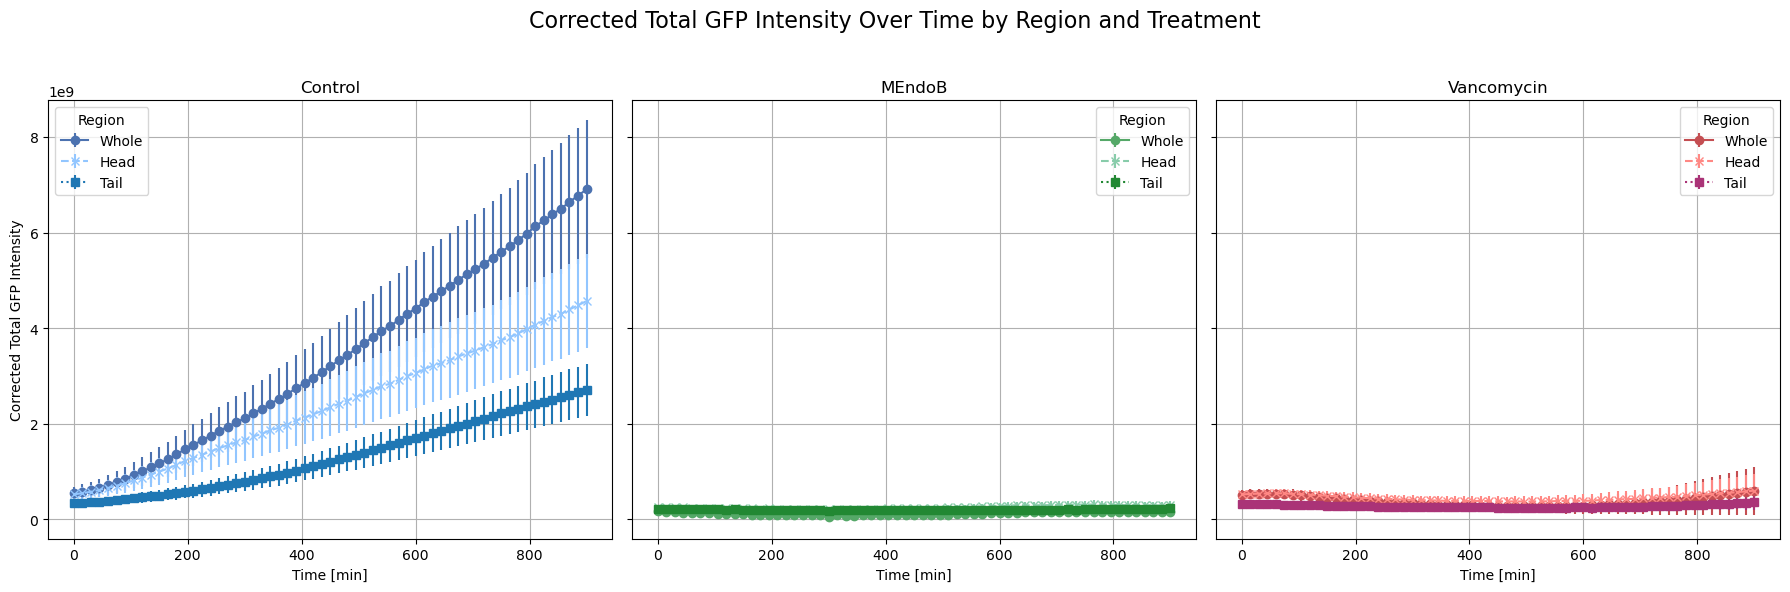

In [4]:
# --- Line Plot for Corrected Total GFP Intensities (Head, Tail, Whole Fish) ---
# Group by Treatment and Time for total GFP intensity
summary_total = df.groupby(['Treatment', 'Time']).agg(
    Whole_Total=('Corrected_Total_GFP_Intensity', 'mean'),
    Whole_SEM=('Corrected_Total_GFP_Intensity', 'sem'),
    Head_Total=('Corrected_Total_Head_Intensity', 'mean'),
    Head_SEM=('Corrected_Total_Head_Intensity', 'sem'),
    Tail_Total=('Corrected_Total_Tail_Intensity', 'mean'),
    Tail_SEM=('Corrected_Total_Tail_Intensity', 'sem'),
).reset_index()

# --- Line Plot for Total GFP Intensities (Subplots with Legends) ---
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), sharey=True)

for ax, treatment in zip(axes, treatments):
    subset = summary_total[summary_total['Treatment'] == treatment]
    
    # Plot each region
    ax.errorbar(subset['Time'], subset['Whole_Total'], yerr=subset['Whole_SEM'], 
                label="Whole", linestyle='-', marker='o', color=colors[treatment][0])
    ax.errorbar(subset['Time'], subset['Head_Total'], yerr=subset['Head_SEM'], 
                label="Head", linestyle='--', marker='x', color=colors[treatment][1])
    ax.errorbar(subset['Time'], subset['Tail_Total'], yerr=subset['Tail_SEM'], 
                label="Tail", linestyle=':', marker='s', color=colors[treatment][2])
    
    # Set axis labels, grid, and title
    ax.set_title(treatment)
    ax.set_xlabel("Time [min]")
    ax.grid()
    
    # Add a legend for each subplot
    ax.legend(title="Region")

# Add shared y-axis label
axes[0].set_ylabel("Corrected Total GFP Intensity")

# Add a shared title and adjust layout
fig.suptitle("Corrected Total GFP Intensity Over Time by Region and Treatment", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


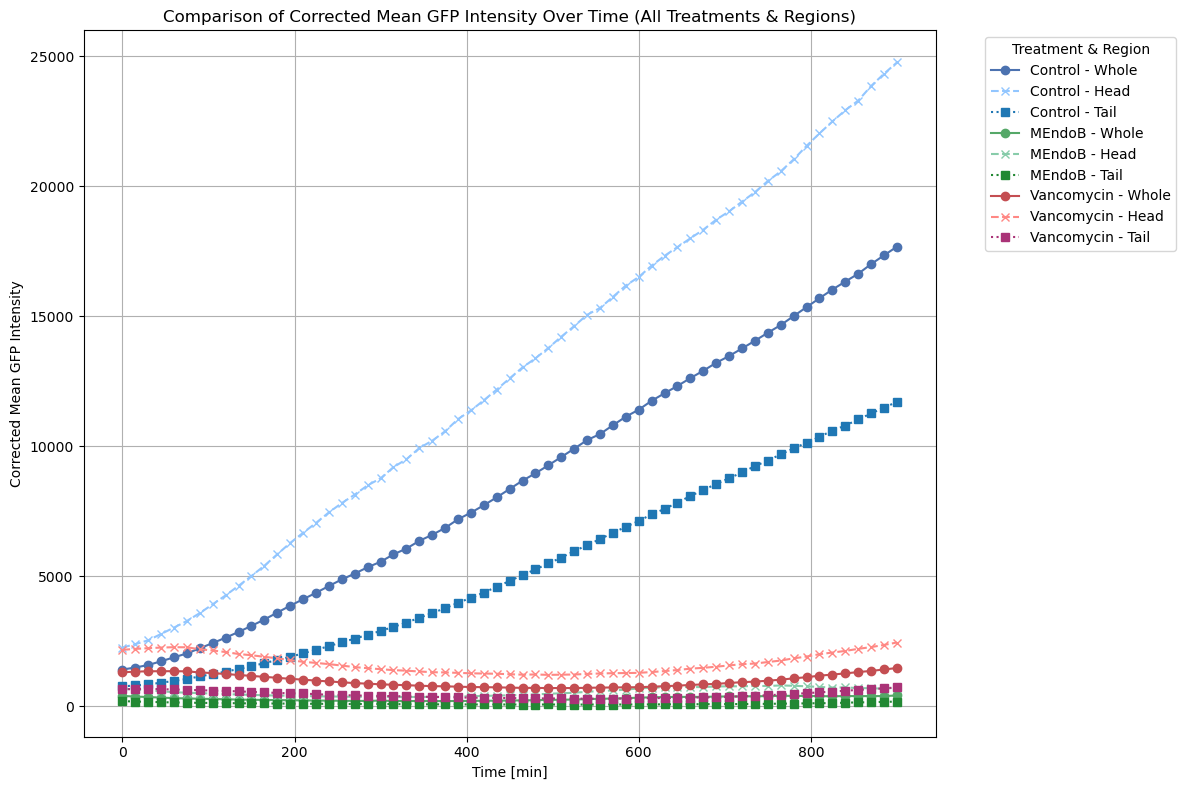

In [5]:
# --- Simple Line Plot for All Treatments and Regions ---
plt.figure(figsize=(12, 8))

for treatment in summary['Treatment'].unique():
    subset = summary[summary['Treatment'] == treatment]
    plt.plot(
        subset['Time'], subset['Whole_Mean'], 
        label=f"{treatment} - Whole", linestyle='-', marker='o', color=colors[treatment][0]
    )
    plt.plot(
        subset['Time'], subset['Head_Mean'], 
        label=f"{treatment} - Head", linestyle='--', marker='x', color=colors[treatment][1]
    )
    plt.plot(
        subset['Time'], subset['Tail_Mean'], 
        label=f"{treatment} - Tail", linestyle=':', marker='s', color=colors[treatment][2]
    )

# Add labels, legend, and title
plt.xlabel("Time [min]")
plt.ylabel("Corrected Mean GFP Intensity")
plt.title("Comparison of Corrected Mean GFP Intensity Over Time (All Treatments & Regions)")
plt.legend(title="Treatment & Region", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()


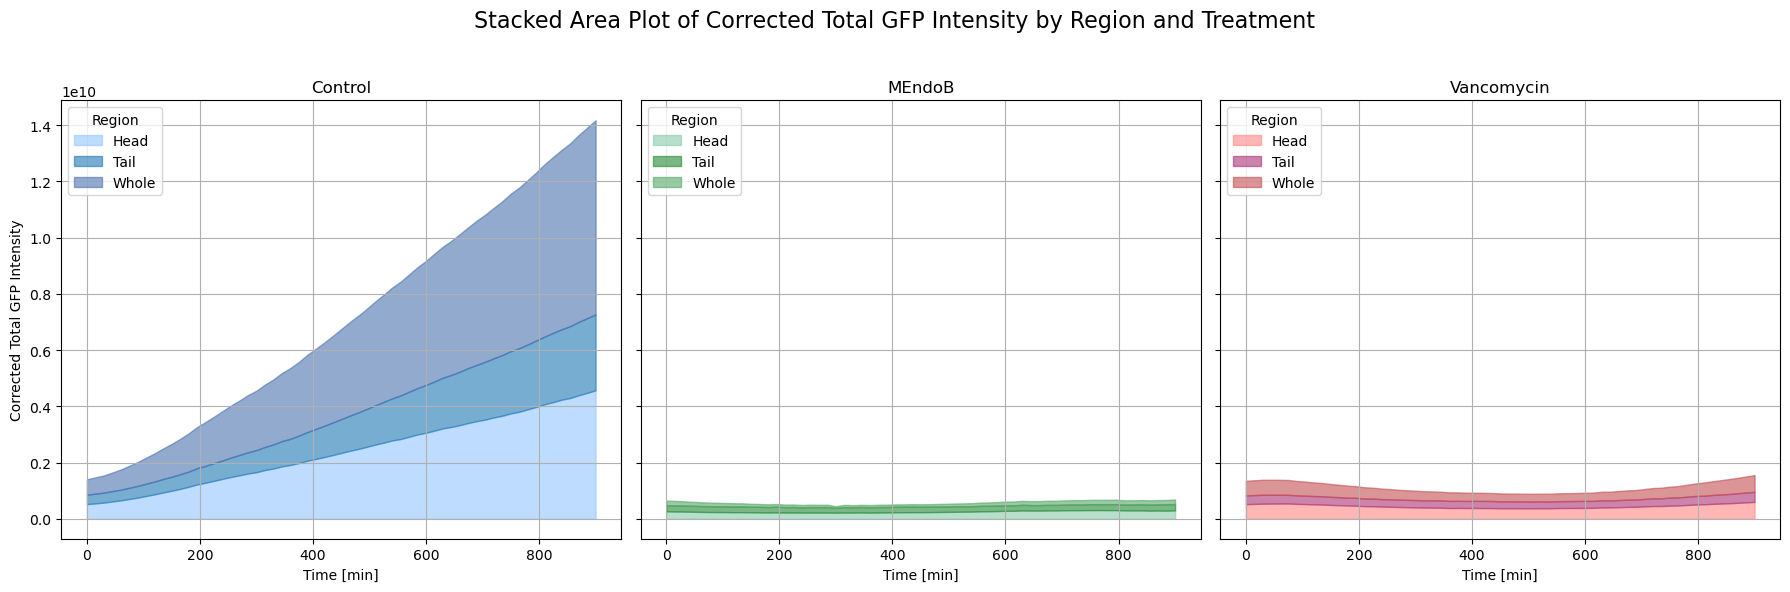

In [6]:
# --- Stacked Area Plot for Corrected Total GFP Intensity ---
# Group by Treatment and Time for total GFP intensity
summary_total = df.groupby(['Treatment', 'Time']).agg(
    Whole_Total=('Corrected_Total_GFP_Intensity', 'mean'),
    Head_Total=('Corrected_Total_Head_Intensity', 'mean'),
    Tail_Total=('Corrected_Total_Tail_Intensity', 'mean')
).reset_index()

# --- Stacked Area Plot for Total GFP Intensities (Subplots) ---
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), sharey=True)

for ax, treatment in zip(axes, treatments):
    subset = summary_total[summary_total['Treatment'] == treatment]

    # Ensure stacking order: Head + Tail + Whole
    total_sum = subset['Head_Total'] + subset['Tail_Total']
    ax.fill_between(
        subset['Time'], 0, subset['Head_Total'], 
        color=colors[treatment][1], alpha=0.6, label="Head"
    )
    ax.fill_between(
        subset['Time'], subset['Head_Total'], total_sum, 
        color=colors[treatment][2], alpha=0.6, label="Tail"
    )
    ax.fill_between(
        subset['Time'], total_sum, total_sum + subset['Whole_Total'], 
        color=colors[treatment][0], alpha=0.6, label="Whole"
    )

    # Titles and grid
    ax.set_title(treatment)
    ax.set_xlabel("Time [min]")
    ax.grid()

    # Add legend for each plot
    ax.legend(title="Region", loc="upper left")

# Common y-axis label and title
axes[0].set_ylabel("Corrected Total GFP Intensity")
fig.suptitle("Stacked Area Plot of Corrected Total GFP Intensity by Region and Treatment", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


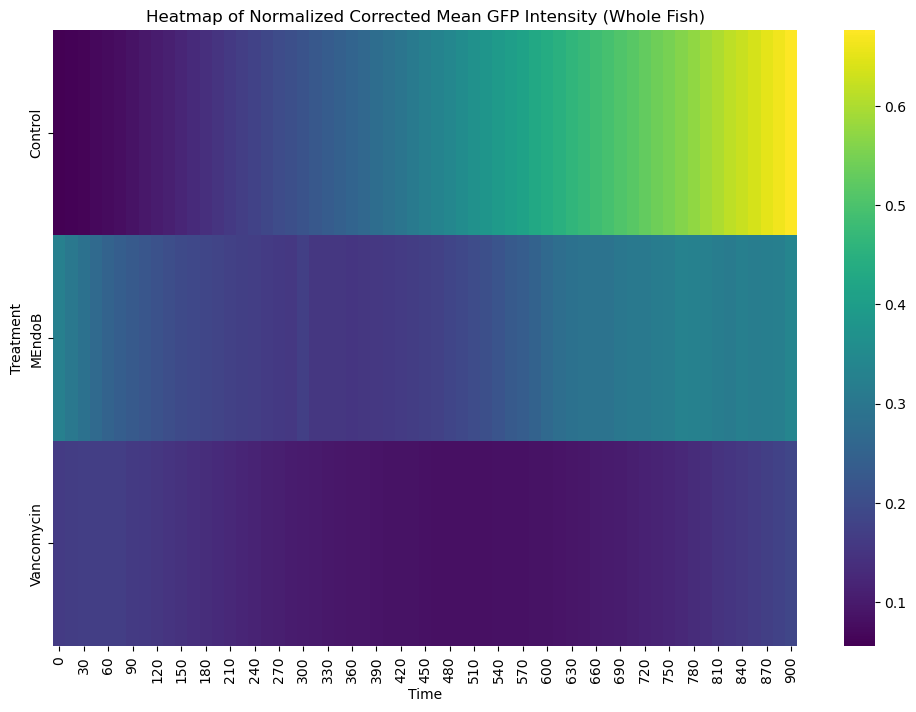

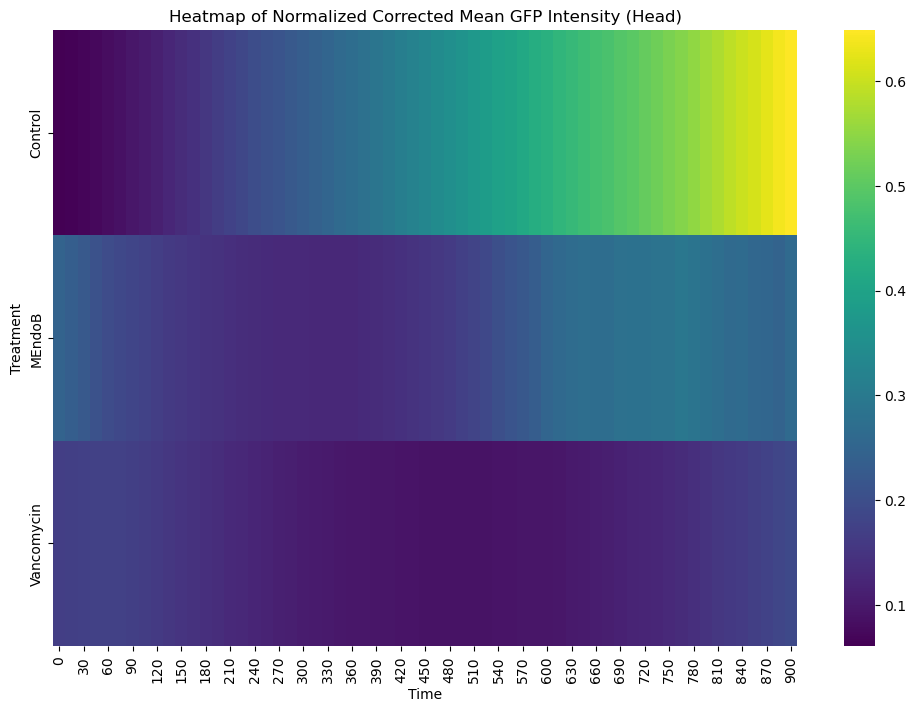

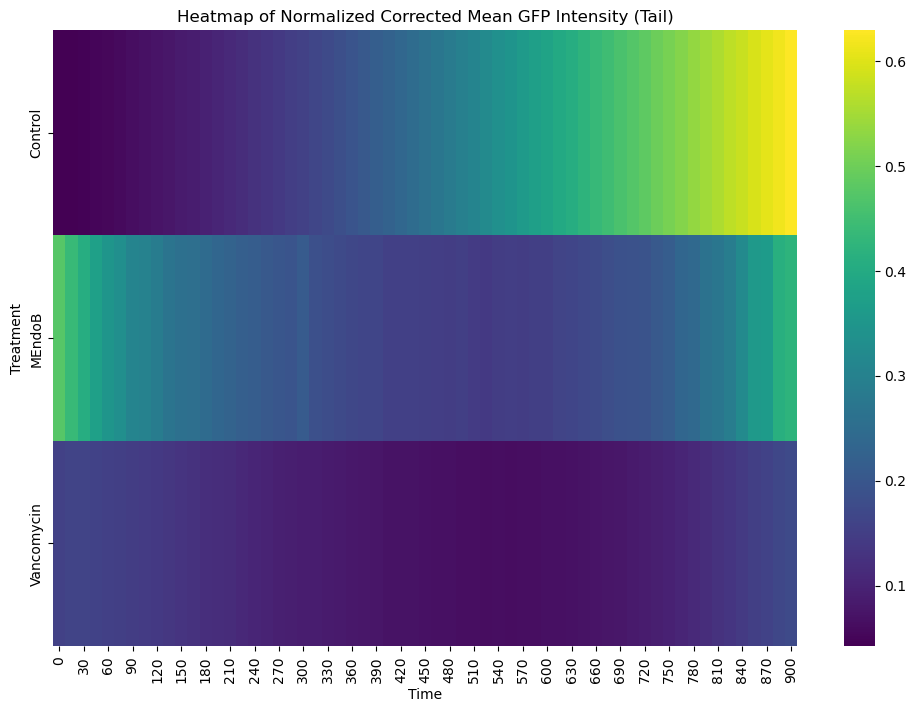

In [7]:
# --- Heatmap of Normalized Corrected Mean GFP Intensities ---
# Normalize intensities within each region
df['Normalized_Whole_Mean'] = df.groupby('Treatment')['Corrected_Mean_GFP_Intensity'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
df['Normalized_Head_Mean'] = df.groupby('Treatment')['Corrected_Mean_Head_Intensity'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
df['Normalized_Tail_Mean'] = df.groupby('Treatment')['Corrected_Mean_Tail_Intensity'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

# Pivot for heatmap
heatmap_data = df.pivot_table(index='Treatment', columns='Time', values='Normalized_Whole_Mean', aggfunc='mean')
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='viridis', annot=False)
plt.title("Heatmap of Normalized Corrected Mean GFP Intensity (Whole Fish)")
plt.show()

# Separate heatmaps for head and tail
for region, column in [('Head', 'Normalized_Head_Mean'), ('Tail', 'Normalized_Tail_Mean')]:
    heatmap_data = df.pivot_table(index='Treatment', columns='Time', values=column, aggfunc='mean')
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data, cmap='viridis', annot=False)
    plt.title(f"Heatmap of Normalized Corrected Mean GFP Intensity ({region})")
    plt.show()

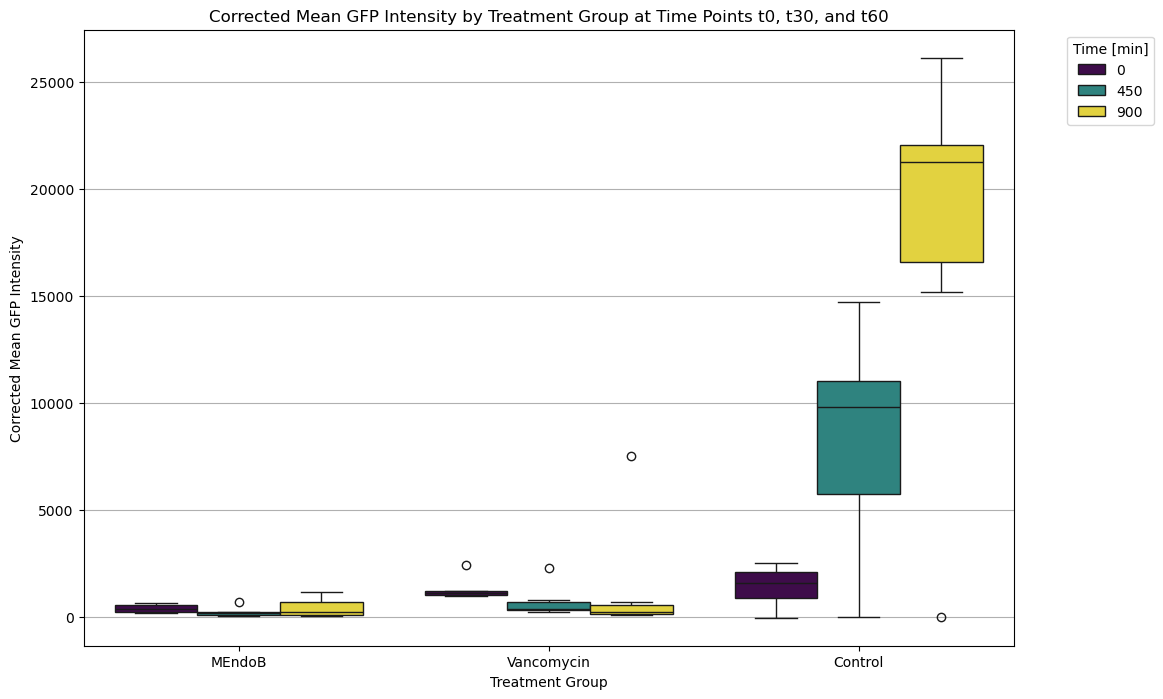

In [8]:
# Create boxplot for corrected mean GFP intensity by treatment group for time points t0, t30 and t60
plt.figure(figsize=(12, 8))
sns.boxplot(data=df[df['Time'].isin([0, 450, 900])], x='Treatment', y='Corrected_Mean_GFP_Intensity', hue='Time', palette='viridis')  # Time points can be adjusted
plt.xlabel("Treatment Group")
plt.ylabel("Corrected Mean GFP Intensity")
plt.title("Corrected Mean GFP Intensity by Treatment Group at Time Points t0, t30, and t60")
plt.grid(axis='y')
plt.legend(title="Time [min]", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()